In [1]:
import pandas as pd
import numpy as np

# Load the dataset
df = pd.read_csv('/content/drive/MyDrive/ML Projects/Chemicals in Cosmetics/chemicals-in-cosmetics.csv')

# Group by CDPHId and take the first value for metadata (assumed consistent per product)
product_df = df.groupby('CDPHId').agg({
    'ProductName': 'first',
    'CompanyName': 'first',
    'BrandName': 'first',
    'PrimaryCategory': 'first',
    'SubCategory': 'first',
    'CasNumber': lambda x: list(x),  # Collect all CAS numbers as a list
}).reset_index()

In [2]:
# Placeholder function (replace with actual Proposition 65 mapping)
def get_hazard_types(cas_number):
    # Example mapping (simplified)
    prop65_dict = {
        '13463-67-7': {'cancer'},  # Titanium dioxide
        '65996-92-1': {'cancer'},  # Distillates (coal tar)
        '140-67-0': {'reproductive_harm'}  # Estragole
    }
    return prop65_dict.get(cas_number, set())

# Apply to each product's CAS list
def product_hazards(cas_list):
    hazards = set()
    for cas in cas_list:
        hazards.update(get_hazard_types(cas))
    return hazards

product_df['hazards'] = product_df['CasNumber'].apply(product_hazards)
product_df['contains_cancer_chemicals'] = product_df['hazards'].apply(lambda x: 'cancer' in x).astype(int)
product_df['contains_reproductive_harm_chemicals'] = product_df['hazards'].apply(lambda x: 'reproductive_harm' in x).astype(int)

# Drop temporary column
product_df = product_df.drop('hazards', axis=1)

In [7]:
product_df = product_df.dropna(subset=['BrandName'])

In [8]:
print(product_df.isnull().sum())

CDPHId                                  0
ProductName                             0
CompanyName                             0
BrandName                               0
PrimaryCategory                         0
SubCategory                             0
CasNumber                               0
contains_cancer_chemicals               0
contains_reproductive_harm_chemicals    0
BrandName_freq                          0
CompanyName_freq                        0
dtype: int64


In [9]:
from sklearn.preprocessing import OneHotEncoder

# One-hot encoding
ohe = OneHotEncoder(sparse_output=True, handle_unknown='ignore')
category_features = ohe.fit_transform(product_df[['PrimaryCategory', 'SubCategory']])

# Frequency encoding
brand_freq = product_df['BrandName'].value_counts(normalize=True)
company_freq = product_df['CompanyName'].value_counts(normalize=True)
product_df['BrandName_freq'] = product_df['BrandName'].map(brand_freq)
product_df['CompanyName_freq'] = product_df['CompanyName'].map(company_freq)

# Combine features
from scipy.sparse import hstack
features = hstack([category_features, product_df[['BrandName_freq', 'CompanyName_freq']].values])

In [10]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features.toarray())  # Convert sparse to dense if needed
print(f"Reduced to {features_pca.shape[1]} features")

Reduced to 32 features


In [11]:
from sklearn.model_selection import train_test_split
targets = product_df[['contains_cancer_chemicals', 'contains_reproductive_harm_chemicals']].values
X_train, X_test, y_train, y_test = train_test_split(features_pca, targets, test_size=0.2, random_state=42)

In [12]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_cancer, y_train_cancer = smote.fit_resample(X_train, y_train[:, 0])
X_train_repro, y_train_repro = smote.fit_resample(X_train, y_train[:, 1])

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier

models = [
    ('LR', LogisticRegression(max_iter=1000)),
    ('DT', DecisionTreeClassifier()),
    ('RF', RandomForestClassifier()),
    ('XGB', XGBClassifier(use_label_encoder=False, eval_metric='logloss')),
    ('SVM', SVC(probability=True)),
    ('KNN', KNeighborsClassifier()),
    ('NB', GaussianNB()),
    ('Ada', AdaBoostClassifier()),
    ('Bag', BaggingClassifier()),
    ('MLP', MLPClassifier(max_iter=500))
]

In [14]:
from sklearn.model_selection import GridSearchCV
param_grid = {'n_estimators': [50, 100], 'max_depth': [10, 20]}
rf = RandomForestClassifier()
grid = GridSearchCV(rf, param_grid, cv=5, scoring='f1')
grid.fit(X_train_cancer, y_train_cancer)
best_rf = grid.best_estimator_

In [15]:
from sklearn.ensemble import VotingClassifier
voting_clf_cancer = VotingClassifier(estimators=models, voting='soft')
voting_clf_cancer.fit(X_train_cancer, y_train_cancer)

voting_clf_repro = VotingClassifier(estimators=models, voting='soft')
voting_clf_repro.fit(X_train_repro, y_train_repro)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:27:04] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [19:41:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


VotingClassifier(estimators=[('LR', LogisticRegression(max_iter=1000)),
                             ('DT', DecisionTreeClassifier()),
                             ('RF', RandomForestClassifier()),
                             ('XGB',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric='logloss...
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...)),
                             ('SVM', SVC(probability=True)),
                             ('KNN', KNeighborsClassifier()),
                             ('NB', GaussianNB()),
                             ('Ada', AdaBoostClassifier()),
                             ('Bag', BaggingClassifier()),
                             ('MLP', MLPClassifier(max_iter=500))],
                 voting='soft')

In [16]:
from sklearn.metrics import classification_report, roc_auc_score
y_pred_cancer = voting_clf_cancer.predict(X_test)
y_pred_repro = voting_clf_repro.predict(X_test)

print("Cancer Chemicals Classification:")
print(classification_report(y_test[:, 0], y_pred_cancer))
print("ROC-AUC:", roc_auc_score(y_test[:, 0], voting_clf_cancer.predict_proba(X_test)[:, 1]))

print("Reproductive Harm Chemicals Classification:")
print(classification_report(y_test[:, 1], y_pred_repro))
print("ROC-AUC:", roc_auc_score(y_test[:, 1], voting_clf_repro.predict_proba(X_test)[:, 1]))

Cancer Chemicals Classification:
              precision    recall  f1-score   support

           0       0.61      0.83      0.71      1018
           1       0.97      0.91      0.94      6261

    accuracy                           0.90      7279
   macro avg       0.79      0.87      0.82      7279
weighted avg       0.92      0.90      0.91      7279

ROC-AUC: 0.9387656898710922
Reproductive Harm Chemicals Classification:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      7253
           1       0.09      0.65      0.16        26

    accuracy                           0.98      7279
   macro avg       0.55      0.82      0.58      7279
weighted avg       1.00      0.98      0.98      7279

ROC-AUC: 0.9242992289662634


In [17]:
rf_cancer = RandomForestClassifier().fit(X_train_cancer, y_train_cancer)
importances = rf_cancer.feature_importances_
feature_names = ohe.get_feature_names_out().tolist() + ['BrandName_freq', 'CompanyName_freq']
importance_df = pd.DataFrame({'Feature': feature_names[:len(importances)], 'Importance': importances})
print(importance_df.sort_values('Importance', ascending=False))

                                              Feature  Importance
1                       PrimaryCategory_Bath Products    0.092072
0                       PrimaryCategory_Baby Products    0.059449
2                          PrimaryCategory_Fragrances    0.054675
25          SubCategory_Bubble and Foam Bath Products    0.048954
23                               SubCategory_Blushes     0.047493
16  SubCategory_Antiperspirants (making a cosmetic...    0.039818
24                  SubCategory_Body Washes and Soaps    0.034408
13  SubCategory_Acne Products (making a cosmetic c...    0.032873
22                         SubCategory_Bath Additives    0.029674
26                                SubCategory_Cologne    0.029299
18                          SubCategory_Baby Shampoos    0.029156
10                PrimaryCategory_Skin Care Products     0.028810
14                    SubCategory_Aftershave Products    0.028776
30                                SubCategory_Douches    0.028615
3   Primar

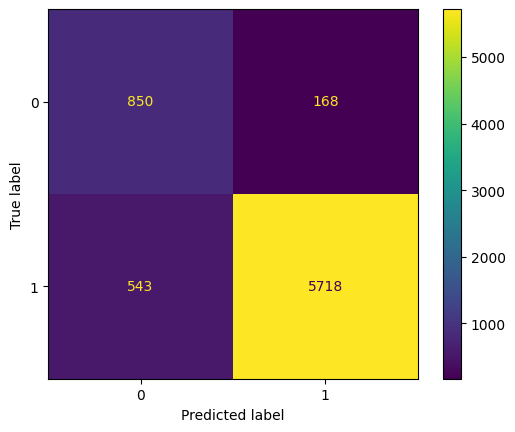

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test[:, 0], y_pred_cancer)
ConfusionMatrixDisplay(cm).plot()
plt.show()

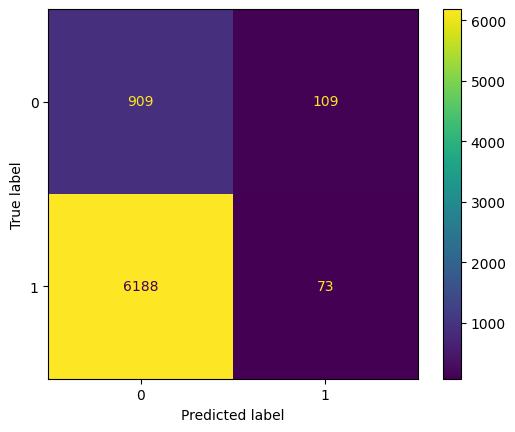

In [21]:
cm = confusion_matrix(y_test[:, 0], y_pred_repro)
ConfusionMatrixDisplay(cm).plot()
plt.show()

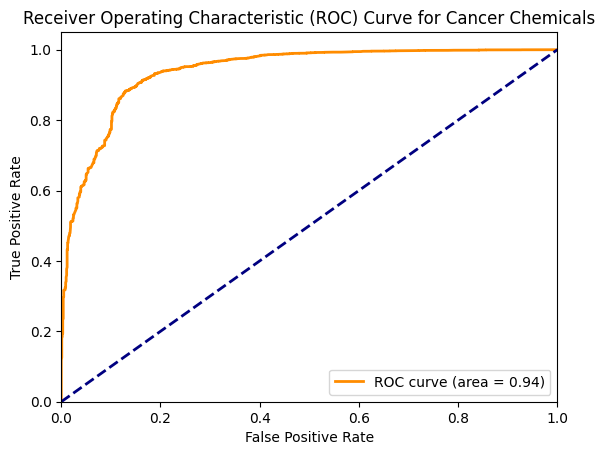

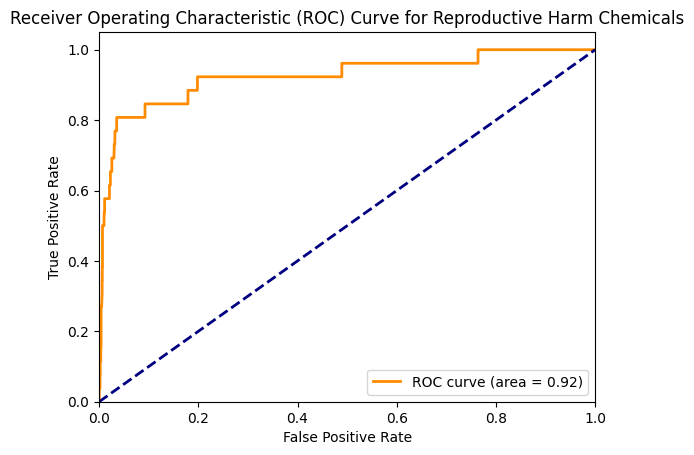

In [23]:
# prompt: plot the ROC curve

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming 'voting_clf_cancer' and 'X_test', 'y_test' are defined as in your original code

# Predict probabilities for the positive class
y_prob_cancer = voting_clf_cancer.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test[:, 0], y_prob_cancer)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Cancer Chemicals')
plt.legend(loc="lower right")
plt.show()


# Similarly for reproductive harm
y_prob_repro = voting_clf_repro.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test[:, 1], y_prob_repro)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Reproductive Harm Chemicals')
plt.legend(loc="lower right")
plt.show()
